# Exploratory Data Analysis

In [1]:
!pip install pyspark

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.0/317.0 MB 2.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.5.1-py2.py3-none-any.whl size=317488491 sha256=0643f0c65ecf67b9cd28b8bf54b2758a611b135f0453fba6d034f4141eb58f38
  Stored in directory: /root/.cache/pip/wheels/80/1d/60/2c256ed38dddce2fdd93be545214a63e02fbd8d74fb0b7f3a6
Successfully built pyspark


In [2]:
import os
import pyspark
import matplotlib.pyplot as plt
import pyspark as ps
from pyspark.sql import SparkSession

In [5]:
# Building a spark session
spark = SparkSession.builder.appName("NYPDArrestData").getOrCreate()

In [6]:
df = spark.read.csv("NYPD_Arrest_Data__Year_to_Date__20240501.csv",header=True,inferSchema=True)
df.show(5)

+----------+-----------+-----+--------------------+-----+--------------------+----------+----------+-----------+---------------+-----------------+---------+--------+--------------+----------+----------+----------------+-----------------+------------------------+
|ARREST_KEY|ARREST_DATE|PD_CD|             PD_DESC|KY_CD|           OFNS_DESC|  LAW_CODE|LAW_CAT_CD|ARREST_BORO|ARREST_PRECINCT|JURISDICTION_CODE|AGE_GROUP|PERP_SEX|     PERP_RACE|X_COORD_CD|Y_COORD_CD|        Latitude|        Longitude|New Georeferenced Column|
+----------+-----------+-----+--------------------+-----+--------------------+----------+----------+-----------+---------------+-----------------+---------+--------+--------------+----------+----------+----------------+-----------------+------------------------+
| 280255493| 01/10/2024|  397|ROBBERY,OPEN AREA...|  105|             ROBBERY|PL 1601001|         F|          M|             26|                0|      <18|       M|         BLACK|    996342|    236149|       40

In [7]:
df.dtypes

[('ARREST_KEY', 'int'),
 ('ARREST_DATE', 'string'),
 ('PD_CD', 'int'),
 ('PD_DESC', 'string'),
 ('KY_CD', 'int'),
 ('OFNS_DESC', 'string'),
 ('LAW_CODE', 'string'),
 ('LAW_CAT_CD', 'string'),
 ('ARREST_BORO', 'string'),
 ('ARREST_PRECINCT', 'int'),
 ('JURISDICTION_CODE', 'int'),
 ('AGE_GROUP', 'string'),
 ('PERP_SEX', 'string'),
 ('PERP_RACE', 'string'),
 ('X_COORD_CD', 'int'),
 ('Y_COORD_CD', 'int'),
 ('Latitude', 'double'),
 ('Longitude', 'double'),
 ('New Georeferenced Column', 'string')]

In [8]:
filtered_df = df.select(
    "ARREST_DATE",
    "PD_DESC",
    "OFNS_DESC",
    "LAW_CAT_CD",
    "ARREST_BORO",
    "AGE_GROUP",
    "PERP_SEX",
    "PERP_RACE",
    "Latitude",
    "Longitude"
)
filtered_df.show(5)

+-----------+--------------------+--------------------+----------+-----------+---------+--------+--------------+----------------+-----------------+
|ARREST_DATE|             PD_DESC|           OFNS_DESC|LAW_CAT_CD|ARREST_BORO|AGE_GROUP|PERP_SEX|     PERP_RACE|        Latitude|        Longitude|
+-----------+--------------------+--------------------+----------+-----------+---------+--------+--------------+----------------+-----------------+
| 01/10/2024|ROBBERY,OPEN AREA...|             ROBBERY|         F|          M|      <18|       M|         BLACK|       40.814845|       -73.956312|
| 01/02/2024|              RAPE 1|                RAPE|         F|          K|    25-44|       M|WHITE HISPANIC|40.6744956865259|-73.9305713255961|
| 01/03/2024|           ASSAULT 3|ASSAULT 3 & RELAT...|         M|          Q|      65+|       F|         WHITE|       40.662526|       -73.846499|
| 01/19/2024|CONTROLLED SUBSTA...|     DANGEROUS DRUGS|         M|          B|    45-64|       M|         BLACK|

In [9]:
# filtered_df['OFNS_DESC'].value_counts()

filtered_df.groupBy('OFNS_DESC').count().orderBy('count', ascending=False).show()

+--------------------+-----+
|           OFNS_DESC|count|
+--------------------+-----+
|ASSAULT 3 & RELAT...| 8960|
|       PETIT LARCENY| 6526|
|      FELONY ASSAULT| 5288|
|     DANGEROUS DRUGS| 4733|
|MISCELLANEOUS PEN...| 3992|
|VEHICLE AND TRAFF...| 3923|
|       GRAND LARCENY| 3068|
|             ROBBERY| 2945|
|CRIMINAL MISCHIEF...| 2817|
|   DANGEROUS WEAPONS| 2509|
|OTHER OFFENSES RE...| 2227|
|OFFENSES AGAINST ...| 1981|
|            BURGLARY| 1599|
|OFFENSES INVOLVIN...| 1384|
|          SEX CRIMES| 1383|
|             FORGERY| 1293|
|OFF. AGNST PUB OR...| 1138|
|POSSESSION OF STO...| 1064|
|   CRIMINAL TRESPASS|  762|
|OTHER TRAFFIC INF...|  707|
+--------------------+-----+
only showing top 20 rows



In [10]:
filtered_df.groupBy('LAW_CAT_CD').count().orderBy('count', ascending=False).show()

+----------+-----+
|LAW_CAT_CD|count|
+----------+-----+
|         M|35580|
|         F|26653|
|         V|  775|
|      NULL|  402|
|         9|  155|
|         I|   54|
|    (null)|    2|
+----------+-----+



In [12]:
from pyspark.sql.functions import col
lat_df = filtered_df.withColumn("Latitude", col("Latitude").cast("integer"))
long_df = filtered_df.withColumn("Longitude", col("Longitude").cast("integer"))

print(lat_df.groupBy('Latitude').count().orderBy('count', ascending=False).show())
print(long_df.groupBy('Longitude').count().orderBy('count', ascending=False).show())
del lat_df
del long_df

+--------+-----+
|Latitude|count|
+--------+-----+
|      40|63619|
|       0|    2|
+--------+-----+

None
+---------+-----+
|Longitude|count|
+---------+-----+
|      -73|56939|
|      -74| 6680|
|        0|    2|
+---------+-----+

None


In [13]:
# Filtering for coordinates
clean_filter = (
    (col("Latitude") > 39) &
    (col("Latitude") < 41) &
    (col("Longitude") < -72) &
    (col("Longitude") > -75)
)
cleandf = filtered_df.filter(clean_filter)

# Filtering for Manhattan arrests
man_df = cleandf.filter(col("ARREST_BORO") == "M")

# Describing the data
man_df.describe().show()

+-------+-----------+--------------------+--------------------+----------+-----------+---------+--------+--------------------+-------------------+--------------------+
|summary|ARREST_DATE|             PD_DESC|           OFNS_DESC|LAW_CAT_CD|ARREST_BORO|AGE_GROUP|PERP_SEX|           PERP_RACE|           Latitude|           Longitude|
+-------+-----------+--------------------+--------------------+----------+-----------+---------+--------+--------------------+-------------------+--------------------+
|  count|      15322|               15322|               15322|     15150|      15322|    15322|   15322|               15322|              15322|               15322|
|   mean|       NULL|                NULL|                NULL|       9.0|       NULL|     NULL|    NULL|                NULL|  40.76962551289661|  -73.97280181324393|
| stddev|       NULL|                NULL|                NULL|       0.0|       NULL|     NULL|    NULL|                NULL|0.04124797318985326|0.024841191687

In [25]:
lat_list = [float(row.Latitude) for row in man_df.select('Latitude').collect()]
long_list = [float(row.Longitude) for row in man_df.select('Longitude').collect()]

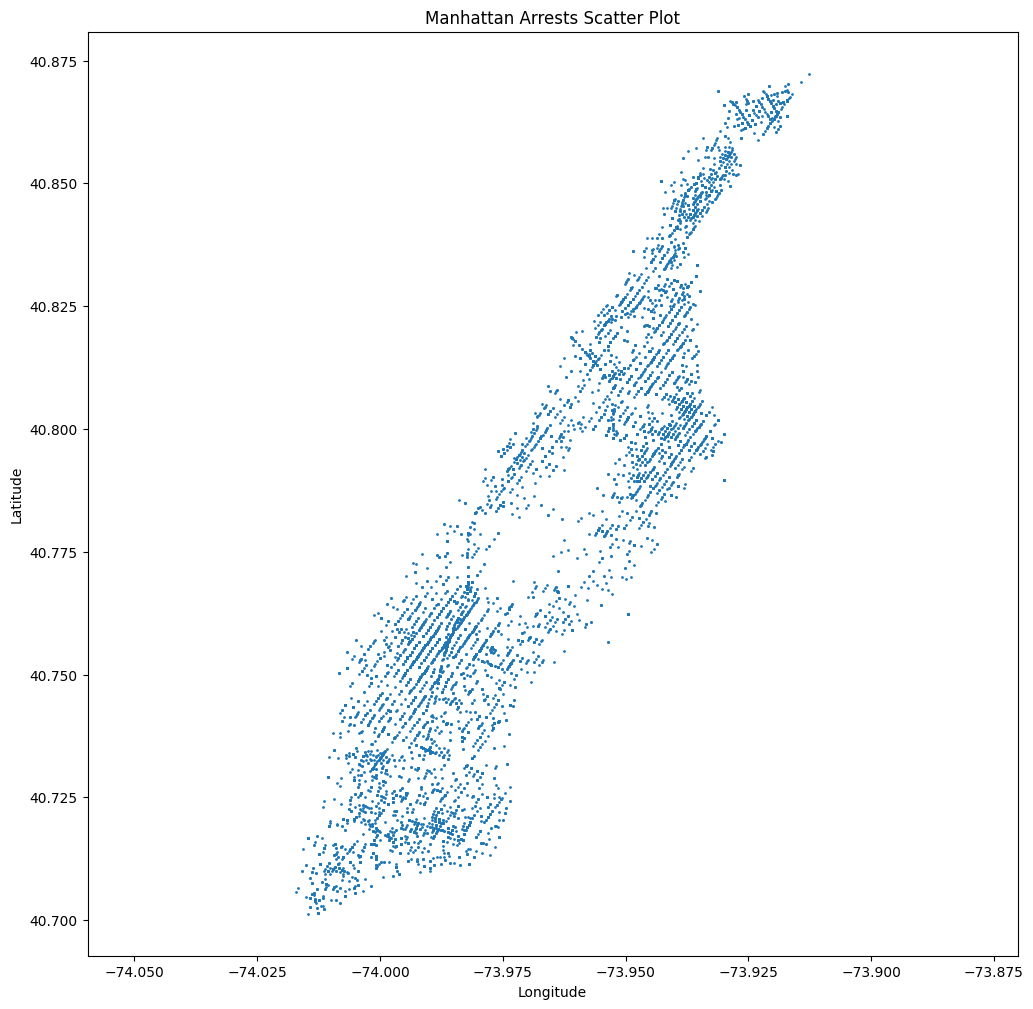

In [42]:
plt.figure(figsize=(12, 12))
plt.axis('equal')
# Basic scatter plot
plt.scatter(long_list, lat_list, s=1)

# Customization (optional)
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("Manhattan Arrests Scatter Plot")

# Display the plot
plt.show()

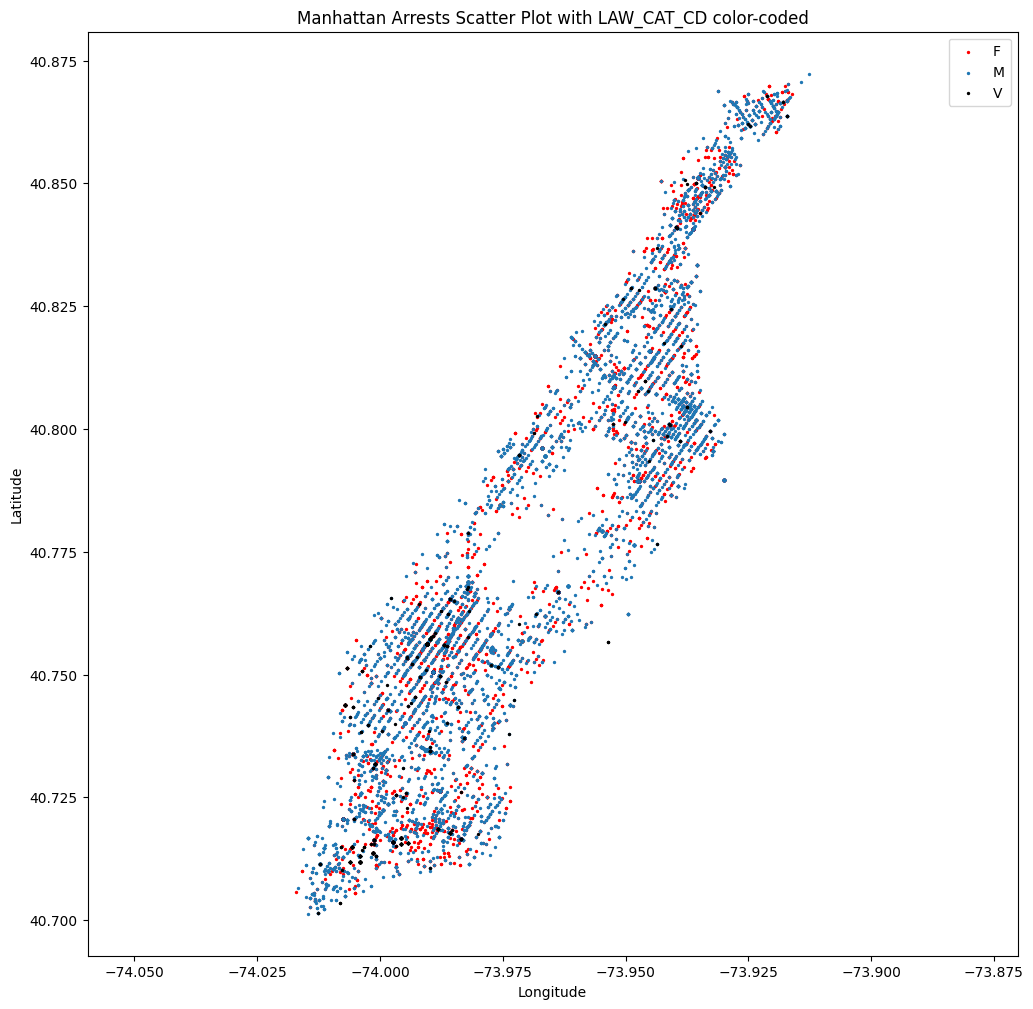

In [41]:
# Now let's do it with colour coded LAW_CAT_CD
import pandas as pd

# Add a new column with category labels
from pyspark.sql.functions import when

man_df = man_df.withColumn('LAW_CAT_CD_label', when(man_df['LAW_CAT_CD'] == 'M', 'M')
                           .otherwise(when(man_df['LAW_CAT_CD'] == 'F', 'F').otherwise('V')))

# Select required columns
subset_df = man_df.select('Latitude', 'Longitude', 'LAW_CAT_CD_label')

# Convert PySpark DataFrame to Pandas DataFrame for easy plotting
pandas_df = subset_df.toPandas()

# Plot the scatter plot
plt.figure(figsize=(12, 12))
plt.axis('equal')

color_mapping = {'F': 'red', 'M': 'C0', 'V': 'black'}
for label, color in color_mapping.items():
    subset = pandas_df[pandas_df['LAW_CAT_CD_label'] == label]
    plt.scatter(subset['Longitude'], subset['Latitude'], color=color, label=label, s=2)

plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Manhattan Arrests Scatter Plot with LAW_CAT_CD color-coded')
plt.legend()
plt.show()
